In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from KNN import KNN
from KNN import LDA
from KNN import RandomForest
import matplotlib.pyplot as plt
from plotter import BoxPlot, OptimismPlot, seaborn_boxplot
from misslabel import misslabel_data_simple, misslabel_data_specified
from helper import Evaluation, doubleCV, CVErrorVSHyperparam


In [ ]:
def main():
    # Load the data
    df = pd.read_csv('data/Numbers.txt', delimiter=' ')
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0]
    
    # train test split
    X_t, X_tst, y_t, y_tst = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    y_t = misslabel_data_simple(y_t, 0.1)

    outerCV = KFold(n_splits=10, shuffle=True, random_state=42)
    foldDataTraining = []
    foldDataTest = []
    #Plot data
    allTestErrors = {}
    optimism = {}
    bestModels = {}
    finalTestErrors = {}

    #Get the folded training and test data
    for train_idx, test_idx in outerCV.split(X_t, y_t):
        X_train = X.iloc[train_idx].to_numpy()
        y_train = y.iloc[train_idx].to_numpy().reshape(-1, 1)

        X_test = X.iloc[test_idx].to_numpy()
        y_test = y.iloc[test_idx].to_numpy().reshape(-1, 1)

        train_combined = np.hstack((y_train, X_train))
        test_combined = np.hstack((y_test, X_test))

        foldDataTraining.append(train_combined)
        foldDataTest.append(test_combined)
    
    """Evaluation without tuning"""

    #KNN small k (flexible)
    kNNClassifier = KNN(n_neighbors=5)
    kNNtrainingErrorsNoTuning, kNNtestErrorsNoTuning ,_,_ = Evaluation(kNNClassifier,foldDataTraining,foldDataTest)
    allTestErrors["KNN (no tuning)"] = kNNtestErrorsNoTuning

    kNNOptimism = np.array(kNNtestErrorsNoTuning) - np.array(kNNtrainingErrorsNoTuning)
    optimism["KNN (no tuning)"] = kNNOptimism

    #KNN large k (rigid)
    kNNClassifierLarge = KNN(n_neighbors=20)
    kNNtrainingErrorsNoTuningLarge, kNNtestErrorsNoTuningLarge ,_,_ = Evaluation(kNNClassifierLarge,foldDataTraining,foldDataTest)
    allTestErrors["KNN LargeK (no tuning)"] = kNNtestErrorsNoTuningLarge
    
    kNNOptimismLarge = np.array(kNNtestErrorsNoTuningLarge) - np.array(kNNtrainingErrorsNoTuningLarge)
    optimism["KNN LargeK (no tuning)"] = kNNOptimismLarge
    
    #LDA 
    
    ldaClassifier = LDA() 
    ldaTrainingErrors, ldaTestErrors, _, _ = Evaluation(ldaClassifier, foldDataTraining, foldDataTest)
    allTestErrors["LDA (no tuning)"] = ldaTestErrors

    LDAOptimism = np.array(ldaTestErrors) - np.array(ldaTrainingErrors)

    optimism["LDA (no tuning)"] = LDAOptimism

    #RandomForest
    rfClassifier = RandomForest()
    rfTrainingErrors, rfTestErrors, _, _ = Evaluation(rfClassifier, foldDataTraining, foldDataTest)
    allTestErrors["Random Forest (no tuning)"] = rfTestErrors

    rfOptimism = np.array(rfTestErrors) - np.array(rfTrainingErrors)

    optimism["Random Forest (no tuning)"] = rfOptimism

    """Evaluation with tuning"""

    #KNN
    
    kNNparamGrid = {'n_neighbors': list(range(1,10))} #k = 1,2,...10 --> Flexible
    kNNparamGridLarge = {'n_neighbors': list(range(15,25))} #k = 15,16,...25 --> Rigid

    kNNtrainingErrors, kNNtestErrors, kNNBestModels, df_kNNTuningResults = doubleCV(foldDataTraining, foldDataTest, KNeighborsClassifier(), kNNparamGrid)
    kNNtrainingErrorsLarge, kNNtestErrorsLarge, kNNBestModelsLarge, df_kNNTuningResultsLarge = doubleCV(foldDataTraining, foldDataTest, KNeighborsClassifier(), kNNparamGridLarge)

    df_kNNTuningResults["Test error"] = 1 - df_kNNTuningResults["mean_test_score"]
    df_kNNTuningResults = df_kNNTuningResults.rename(columns={"param_n_neighbors": "Number of neighbors"})
    df_kNNTuningResults.to_csv("data/kNNTuningResults_task1.csv")
    kNNOptimism_Tuned = np.array(kNNtestErrors) - np.array(kNNtrainingErrors)

    allTestErrors["KNN (tuned)"] = kNNtestErrors
    optimism["KNN (tuned)"] = kNNOptimism_Tuned
    
    df_kNNTuningResultsLarge["Test error"] = 1 - df_kNNTuningResultsLarge["mean_test_score"]
    df_kNNTuningResultsLarge = df_kNNTuningResultsLarge.rename(columns={"param_n_neighbors": "Number of neighbors"})
    df_kNNTuningResultsLarge.to_csv("data/kNNTuningResults_task1_large.csv")
    kNNOptimism_TunedLarge = np.array(kNNtestErrorsLarge) - np.array(kNNtrainingErrorsLarge)
    
    allTestErrors["KNN LargeK (tuned)"] = kNNtestErrorsLarge
    optimism["KNN LargeK (tuned)"] = kNNOptimism_TunedLarge

    print("KNN done tuning")

    #LDA
    ldaParamGrid = [
    {'solver': ['svd']}, 
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto']}
    ]

    ldaTrainingErrors, ldaTestErrors, ldaBestModels, df_ldaTuningResults = doubleCV(foldDataTraining, foldDataTest, LinearDiscriminantAnalysis(), ldaParamGrid)
    
    df_ldaTuningResults["Test error"] = 1 - df_ldaTuningResults["mean_test_score"]
    # df_ldaTuningResults = df_ldaTuningResults.rename(columns={"param_n_neighbors": "Number of neighbors"})
    df_ldaTuningResults.to_csv("data/ldaTuningResults_task1.csv")

    allTestErrors["LDA (tuned)"] = ldaTestErrors

    LDAOptimism_Tuned = np.array(ldaTestErrors) - np.array(ldaTrainingErrors)
    optimism["LDA (tuned)"] = LDAOptimism_Tuned
    bestModels["LDA (tuned)"] = ldaBestModels

    print("LDA Done tuning")

    # #Random Forest
    rfParamGrid = {
    'n_estimators': [20,50, 100],          # number of trees
    'max_depth': [None, 20,50],         # control overfitting
    'max_features': ['sqrt'],  # feature selection per split
    'min_samples_split': [2, 5,10]          # min samples for splitting
    }
    rfTrainingErrors, rfTestErrors, rfBestModels, df_rfTuningResults = doubleCV(foldDataTraining, foldDataTest, RandomForestClassifier(), rfParamGrid)
    
    df_rfTuningResults["Test error"] = 1 - df_rfTuningResults["mean_test_score"]
    # df_rfTuningResults = df_rfTuningResults.rename(columns={"param_n_neighbors": "Number of neighbors"})
    df_rfTuningResults.to_csv("data/rfTuningResults_task1.csv")
    
    allTestErrors["Random Forest (tuned)"] = rfTestErrors

    rfOptimism_Tuned = np.array(rfTestErrors) - np.array(rfTrainingErrors)
    optimism["Random Forest (tuned)"] = rfOptimism_Tuned
    bestModels["Random Forest (tuned)"] = rfBestModels

    print("randomForest Done tuning")

    ### Converting from dictionaries to pandas dataframe:
    records = []

    for classifier_name in allTestErrors:
        test_errors = allTestErrors[classifier_name]
        optimism_values = optimism.get(classifier_name, [None] * len(test_errors))

        tuned_flag = 'Yes' if "(tuned)" in classifier_name else 'No'

        name = classifier_name.replace(" (no tuning)", "").replace(" (tuned)", "")

        for test_err, opt in zip(test_errors, optimism_values):
            records.append({
                "Classifier": name,
                "Test error": test_err,
                "Optimism": opt,
                "Tuned": tuned_flag
            })

    # Create final DataFrame
    data = pd.DataFrame(records)
    data.to_csv("data/task1_data.csv")
    
    """Evaluate range of hyperparameter values to get plot"""
    #rangeOfk = np.arange(1,10)
    #testErrorsForDifferentK = CVErrorVSHyperparam(KNN, 'n_neighbors', rangeOfk, foldDataTraining, foldDataTest)

    #plt.plot(rangeOfk, testErrorsForDifferentK, marker='o')
    #plt.xlabel("k")
    #plt.ylabel("CV Error")
    #plt.title("Unbiased CV Error vs k")
    #plt.grid(True)
    #plt.show()

    "Get plots"

    seaborn_boxplot(df_kNNTuningResults,"Number of neighbors","Test error") # Plot parameter performance for knn when tuning
   
    # print(data)
    seaborn_boxplot(data,'Classifier','Test error','Tuned')
    # BoxPlot(allTestErrors)
    # OptimismPlot(optimism)

    # Finds the parameter constilation that is most common among the best models from the tuning
    best_kNN_params = pd.Series([model.get_params() for model in kNNBestModels]).mode()[0]
    best_kNN_params_large = pd.Series([model.get_params() for model in kNNBestModelsLarge]).mode()[0]
    best_lda_params = pd.Series([model.get_params() for model in ldaBestModels]).mode()[0]
    best_rf_params = pd.Series([model.get_params() for model in rfBestModels]).mode()[0]

    optimalKNN = KNN(**{k: v for k, v in best_kNN_params.items() if k in ['n_neighbors', 'weights', 'algorithm', 'leaf_size', 'p', 'metric']})
    optimalKNNLarge = KNN(**{k: v for k, v in best_kNN_params_large.items() if k in ['n_neighbors', 'weights', 'algorithm', 'leaf_size', 'p', 'metric']})
    optimalLDA = LDA(**{k: v for k, v in best_lda_params.items() if k in ['solver', 'shrinkage', 'priors', 'n_components', 'store_covariance', 'tol']})
    optimalRF  = RandomForest(**{k: v for k, v in best_rf_params.items() if k in ['n_estimators', 'criterion', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'max_features','bootstrap','random_state']})

    optimal_models = {"KNN":optimalKNN, "KNN LargeK":optimalKNNLarge, "LDA":optimalLDA, "Random forest":optimalRF}
   
    # calculate the final test error for each model
    for name, model in optimal_models.items():
        model.fit(X_t,y_t)
        yPred = model.predict(X_tst)
        error = zero_one_loss(y_tst,yPred)
        finalTestErrors[name] = error
    
    print(finalTestErrors)    


KNN done tuning
LDA Done tuning
randomForest Done tuning


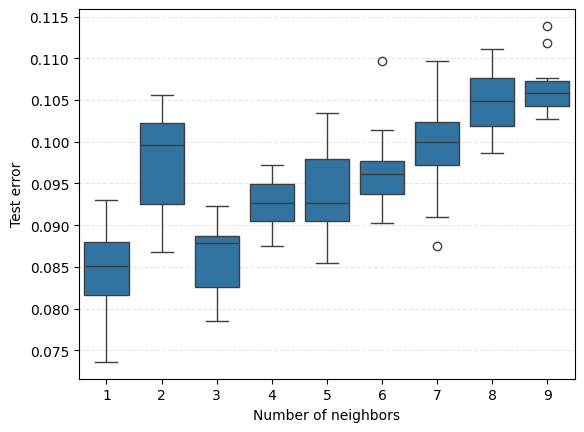

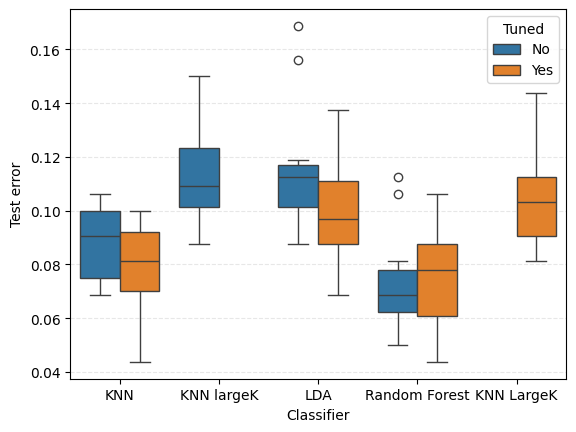

/var/folders/1s/z220kbn525j9yjx9gm24pbv40000gn/T/ipykernel_77350/1505494904.py:185: UserWarning: Unable to sort modes: '<' not supported between instances of 'dict' and 'dict'
  best_kNN_params = pd.Series([model.get_params() for model in kNNBestModels]).mode()[0]


{'KNN': 0.16249999999999998, 'KNN largeK': 0.12250000000000005, 'LDA': 0.11750000000000005, 'Random forest': 0.08250000000000002}


In [27]:
main()